In [1]:
conn_db = 0 # switch to determine whether notebook will connect to database, 0=no, 1=yes
save_figs = 1 # switch to determine whether figures will be saved, 0=no, 1=yes

In [2]:
# Import packages 
import pandas as pd
import sqlite3
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

# Import data and clean

#### We begin by creating a CSV file of the relevant information from the database. Specifically, we aggregate the movie id, movie titles, genres, ratings, and the number of votes for each movie. 

<div align="center">
<img src='imgs/movie_data_erd.jpeg' width="600">
</div>

In [3]:
# Connect to database, create df of relevant info, and save df as csv file for later use 
if conn_db == 1: 
    conn = sqlite3.connect('unzippedData/im.db')
    df_imdb = pd.read_sql("""
    SELECT movie_basics.movie_id, primary_title, runtime_minutes, genres, averagerating, numvotes
    FROM movie_ratings 
    JOIN movie_basics
    ON movie_basics.movie_id = movie_ratings.movie_id
    """, conn)
    df_imdb.head()
    df_imdb.to_csv('data/df_imdb.csv', index=False)

In [4]:
# Import csv file of database info
df_imdb = pd.read_csv('data/df_imdb.csv')

# Clean the genres column
df_imdb['genres'] = df_imdb['genres'].str.split(',')
df_imdb['genres'] = df_imdb['genres'].where(pd.notna(df_imdb['genres']), None)

# Create a new column categorizing runtime
rt_t13 = df_imdb['runtime_minutes'].quantile(1/3)
rt_t23 = df_imdb['runtime_minutes'].quantile(2/3)

df_imdb['rt_cat']= df_imdb['runtime_minutes'].apply(lambda x: None if np.isnan(x) 
                                                       else ('Short' if x <= rt_t13 
                                                             else ('Medium' if x <= rt_t23 else 'Long')))

In [5]:
# Preview df info and first 5 rows 
print('Dataframe description:')
print(df_imdb.describe())
print('\n-----------------------------------------------------------')
print('Dataframe info:')
print(df_imdb.info())
print('\ndf imdb first 5 rows:')
df_imdb.head()

Dataframe description:
       runtime_minutes  averagerating      numvotes
count     66236.000000   73856.000000  7.385600e+04
mean         94.654040       6.332729  3.523662e+03
std         208.574111       1.474978  3.029402e+04
min           3.000000       1.000000  5.000000e+00
25%          81.000000       5.500000  1.400000e+01
50%          91.000000       6.500000  4.900000e+01
75%         104.000000       7.400000  2.820000e+02
max       51420.000000      10.000000  1.841066e+06

-----------------------------------------------------------
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   runtime_minutes  66236 non-null  float64
 3   genres           73052 non-null  object 
 4   averagerating    73856 non-null  float64
 5

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,rt_cat
0,tt10356526,Laiye Je Yaarian,117.0,[Romance],8.3,31,Long
1,tt10384606,Borderless,87.0,[Documentary],8.9,559,Medium
2,tt1042974,Just Inès,90.0,[Drama],6.4,20,Medium
3,tt1043726,The Legend of Hercules,99.0,"[Action, Adventure, Fantasy]",4.2,50352,Long
4,tt1060240,Até Onde?,73.0,"[Mystery, Thriller]",6.5,21,Short


In [6]:
# Import information about budgets and profits
df_finance = pd.read_csv("data/tn.movie_budgets.csv.gz")

# Clean finance columns 
columns_to_clean = ['domestic_gross', 'worldwide_gross', 'production_budget']

for col in columns_to_clean:
    df_finance[col] = df_finance[col].str.replace('[$,]', '', regex=True).astype(np.int64)

#df_finance['release_date'] = pd.to_datetime(df_finance['release_date'])
#df_finance['year'] = df_finance['release_date'].dt.year

# Create new columns for profit and ROI 
df_finance['domestic_profit'] = df_finance['domestic_gross'] - df_finance['production_budget']
df_finance['domestic_roi'] = df_finance['domestic_profit']/df_finance['production_budget']

df_finance['worldwide_profit'] = df_finance['worldwide_gross'] - df_finance['production_budget']
df_finance['worldwide_roi'] = df_finance['worldwide_profit']/df_finance['production_budget']

In [7]:
# Preview df info and first 5 rows 
print('Dataframe description:')
print(df_finance.describe())
print('\n-----------------------------------------------------------')
print('Dataframe info:')
print(df_finance.info())
print('\ndf_finance first 5 rows:')
df_finance.head()

Dataframe description:
                id  production_budget  domestic_gross  worldwide_gross  \
count  5782.000000       5.782000e+03    5.782000e+03     5.782000e+03   
mean     50.372363       3.158776e+07    4.187333e+07     9.148746e+07   
std      28.821076       4.181208e+07    6.824060e+07     1.747200e+08   
min       1.000000       1.100000e+03    0.000000e+00     0.000000e+00   
25%      25.000000       5.000000e+06    1.429534e+06     4.125415e+06   
50%      50.000000       1.700000e+07    1.722594e+07     2.798445e+07   
75%      75.000000       4.000000e+07    5.234866e+07     9.764584e+07   
max     100.000000       4.250000e+08    9.366622e+08     2.776345e+09   

       domestic_profit  domestic_roi  worldwide_profit  worldwide_roi  
count     5.782000e+03   5782.000000      5.782000e+03    5782.000000  
mean      1.028557e+07      1.983540      5.989970e+07       3.800161  
std       4.992137e+07     26.086591      1.460889e+08      29.530282  
min      -3.072376e+08

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,335507625,0.789430,2351345279,5.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,-169536125,-0.412899,635063875,1.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-307237650,-0.877822,-200237650,-0.572108
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,128405868,0.388403,1072413963,3.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,303181382,0.956408,999721747,3.153696


# Merge dataframes and visualize relationships

#### Though we have imdb information from 73856, we only have finance information from 5781. Since we are primarily interested in the movies that have the best financial outcomes, we will focus on those will information in both the imdb and finance dataframes. 

In [8]:
# Prepare columns to merge on
df_imdb['primary_title'] = df_imdb['primary_title'].str.lower()
df_imdb['primary_title'] = df_imdb['primary_title'].str.replace(r'\([^)]*\)', '', regex=True)

df_finance['movie'] = df_finance['movie'].str.lower()
df_finance['movie'] = df_finance['movie'].str.replace(r'\([^)]*\)', '', regex=True)

In [9]:
# Merge dataframe
df_merge = pd.merge(df_finance, df_imdb, left_on='movie', right_on='primary_title', how='inner')

# Drop duplicates in merged dataframe
print(f"df shape before dropping duplicates = {df_merge.shape}")
df_merge = df_merge.drop_duplicates(subset='movie', keep='first')
print(f"df shape after dropping duplicates = {df_merge.shape}\n")

df shape before dropping duplicates = (2935, 17)
df shape after dropping duplicates = (2178, 17)



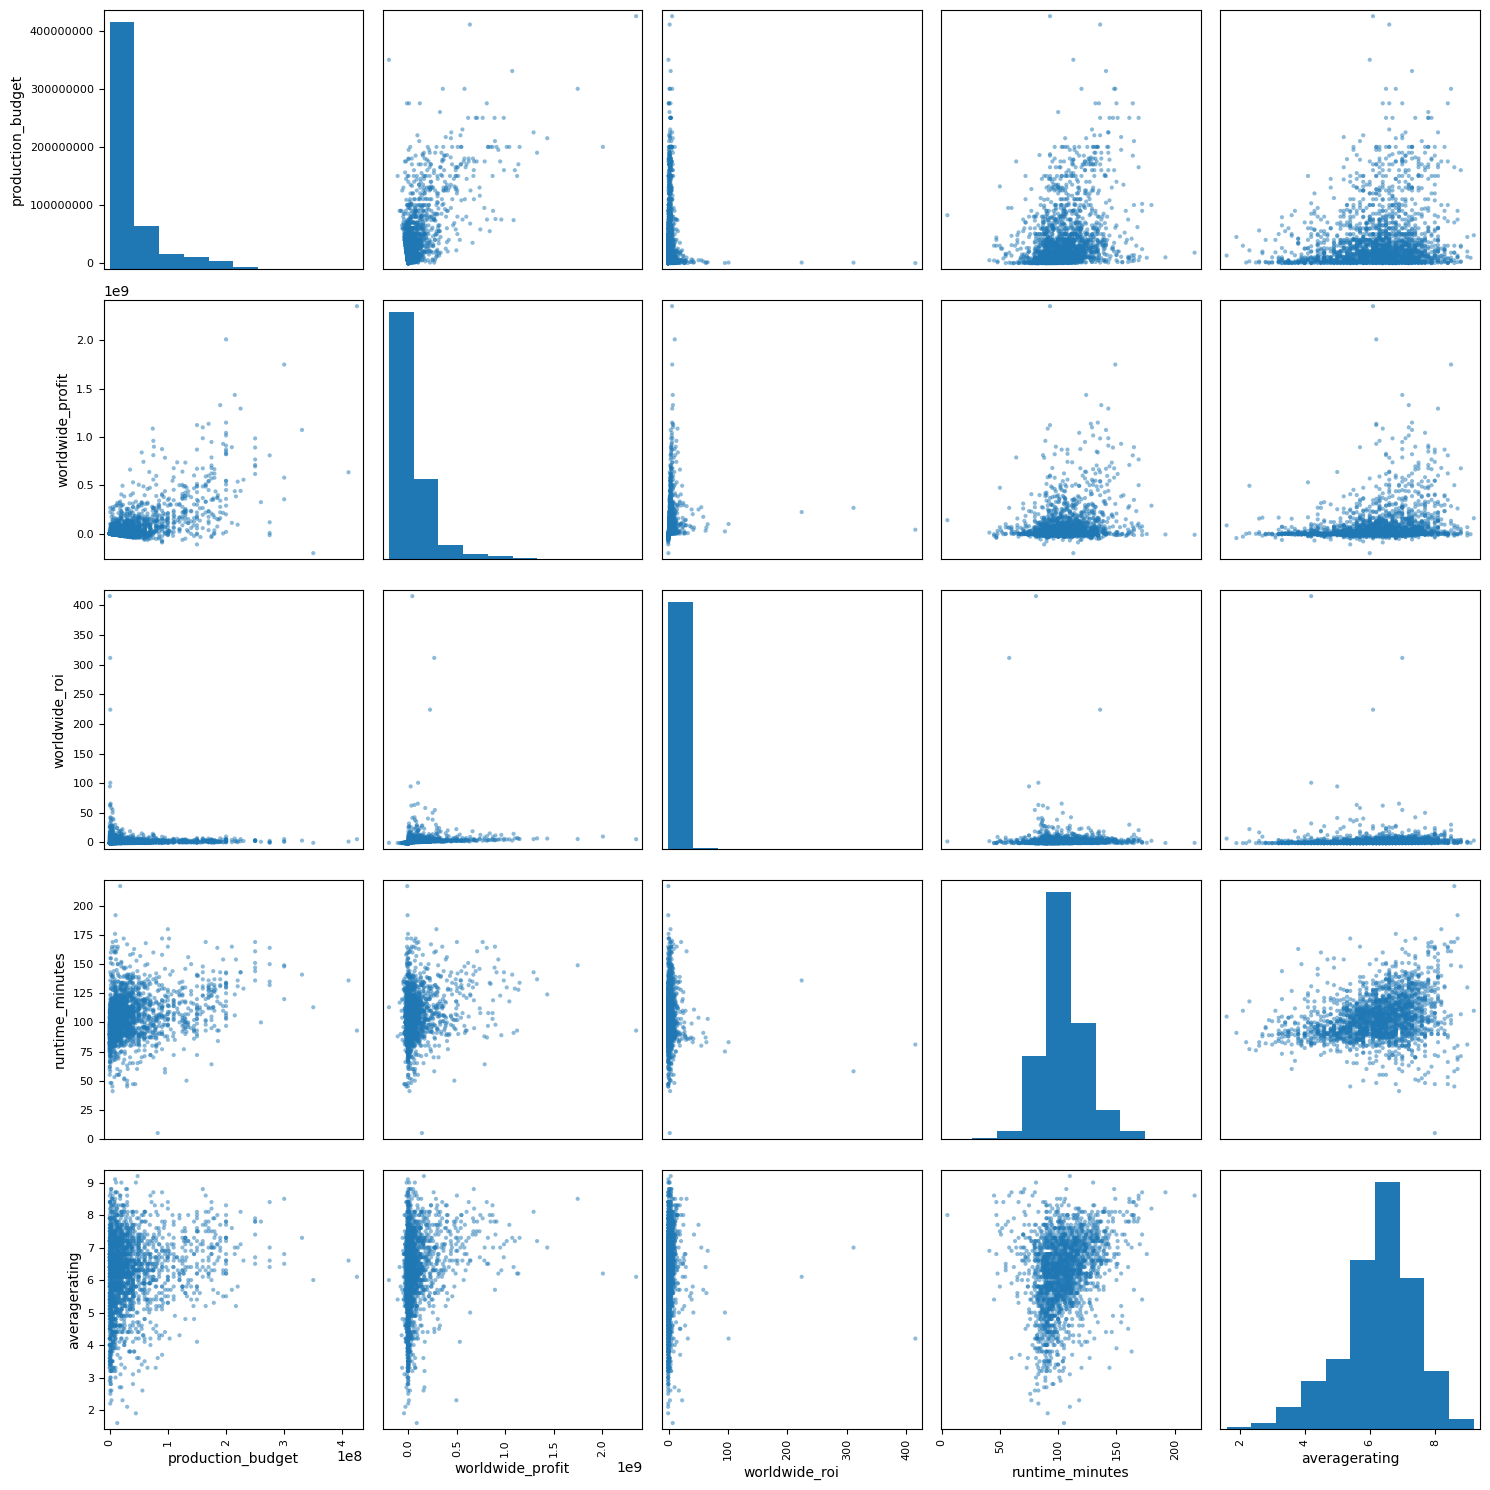

In [10]:
# Visualize the relationships between key metrics in the merged dataframe
axs = pd.plotting.scatter_matrix(df_merge[['production_budget', 'worldwide_profit', 'worldwide_roi', 'runtime_minutes', 'averagerating']], figsize=(15, 15))
plt.tight_layout()
plt.show()

#### We see that the financial columns (production budget, worldwide profit, and worldwide ROI) are heavily skewed such that a few outliers have values far above the others, creating a long right tail. This is most profound for ROI, which suggests it may be noteworthy to explore what factors create exceptionally high ROI values. The other two columns (runtime and average rating) are roughly normally distributed. 

#### There appears to be a positive relationship between budget and profit, however, since our goal is to maximize profit on a small budget, we are primarily seeking to identify trends that vary with ROI specifically. 

#### We don't notice convincing correlations between ROI and rating or runtime. Given this, we will not aim to use quantitative variables (rating and runtime) to predict ROI and will instead focus on identifying categorical variables that maximize ROI. We begin with an exploration of which genre provides the best returns. 

# Genre

Drama          1094
Comedy          664
Action          525
Adventure       402
Thriller        364
Crime           294
Horror          273
Romance         258
Sci-Fi          174
Biography       170
Mystery         166
Fantasy         146
Documentary     126
Family          123
Animation       119
Music            68
History          56
Sport            46
War              29
Musical          15
Western          13
News              1
Name: count, dtype: int64


<Axes: >

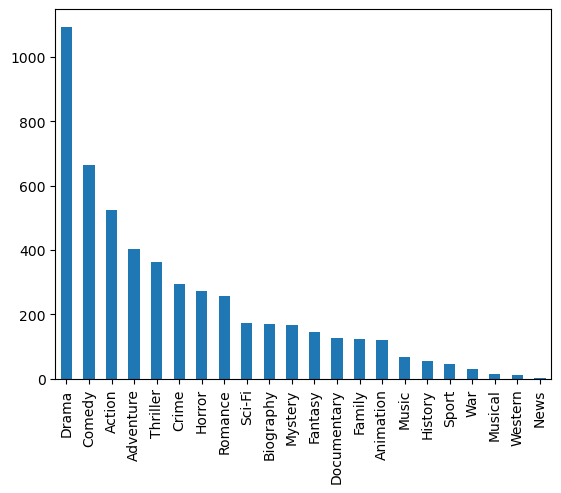

In [11]:
# Calculate and visualize most common genres 
all_genres = [item for sublist in df_merge['genres'] if sublist is not None for item in sublist]
genre_counts = pd.Series(all_genres).value_counts(dropna=False)

print(genre_counts) 
genre_counts.plot(kind='bar')

In [12]:
# Function to get lists of values for each genre
def get_genre_vals(val, df):   
    df_len = len(df)
    all_genre_vals = {}
    
    for genre in genre_counts.index:    
        genre_vals = df[df['genres'].apply(lambda x: genre in x if x is not None else False)][val].values
        genre_len = len(genre_vals) 
        if genre_len < 30:
            continue 
        diff_length = df_len - genre_len
        genre_vals = np.concatenate([genre_vals, [np.nan]*diff_length])
        all_genre_vals[genre] = genre_vals
    all_genre_vals = pd.DataFrame(all_genre_vals)
    all_genre_vals = all_genre_vals.dropna(how='all').reset_index(drop=True)
    return all_genre_vals 

Text(0.5, 1.0, 'Worldwide ROI By Genre')

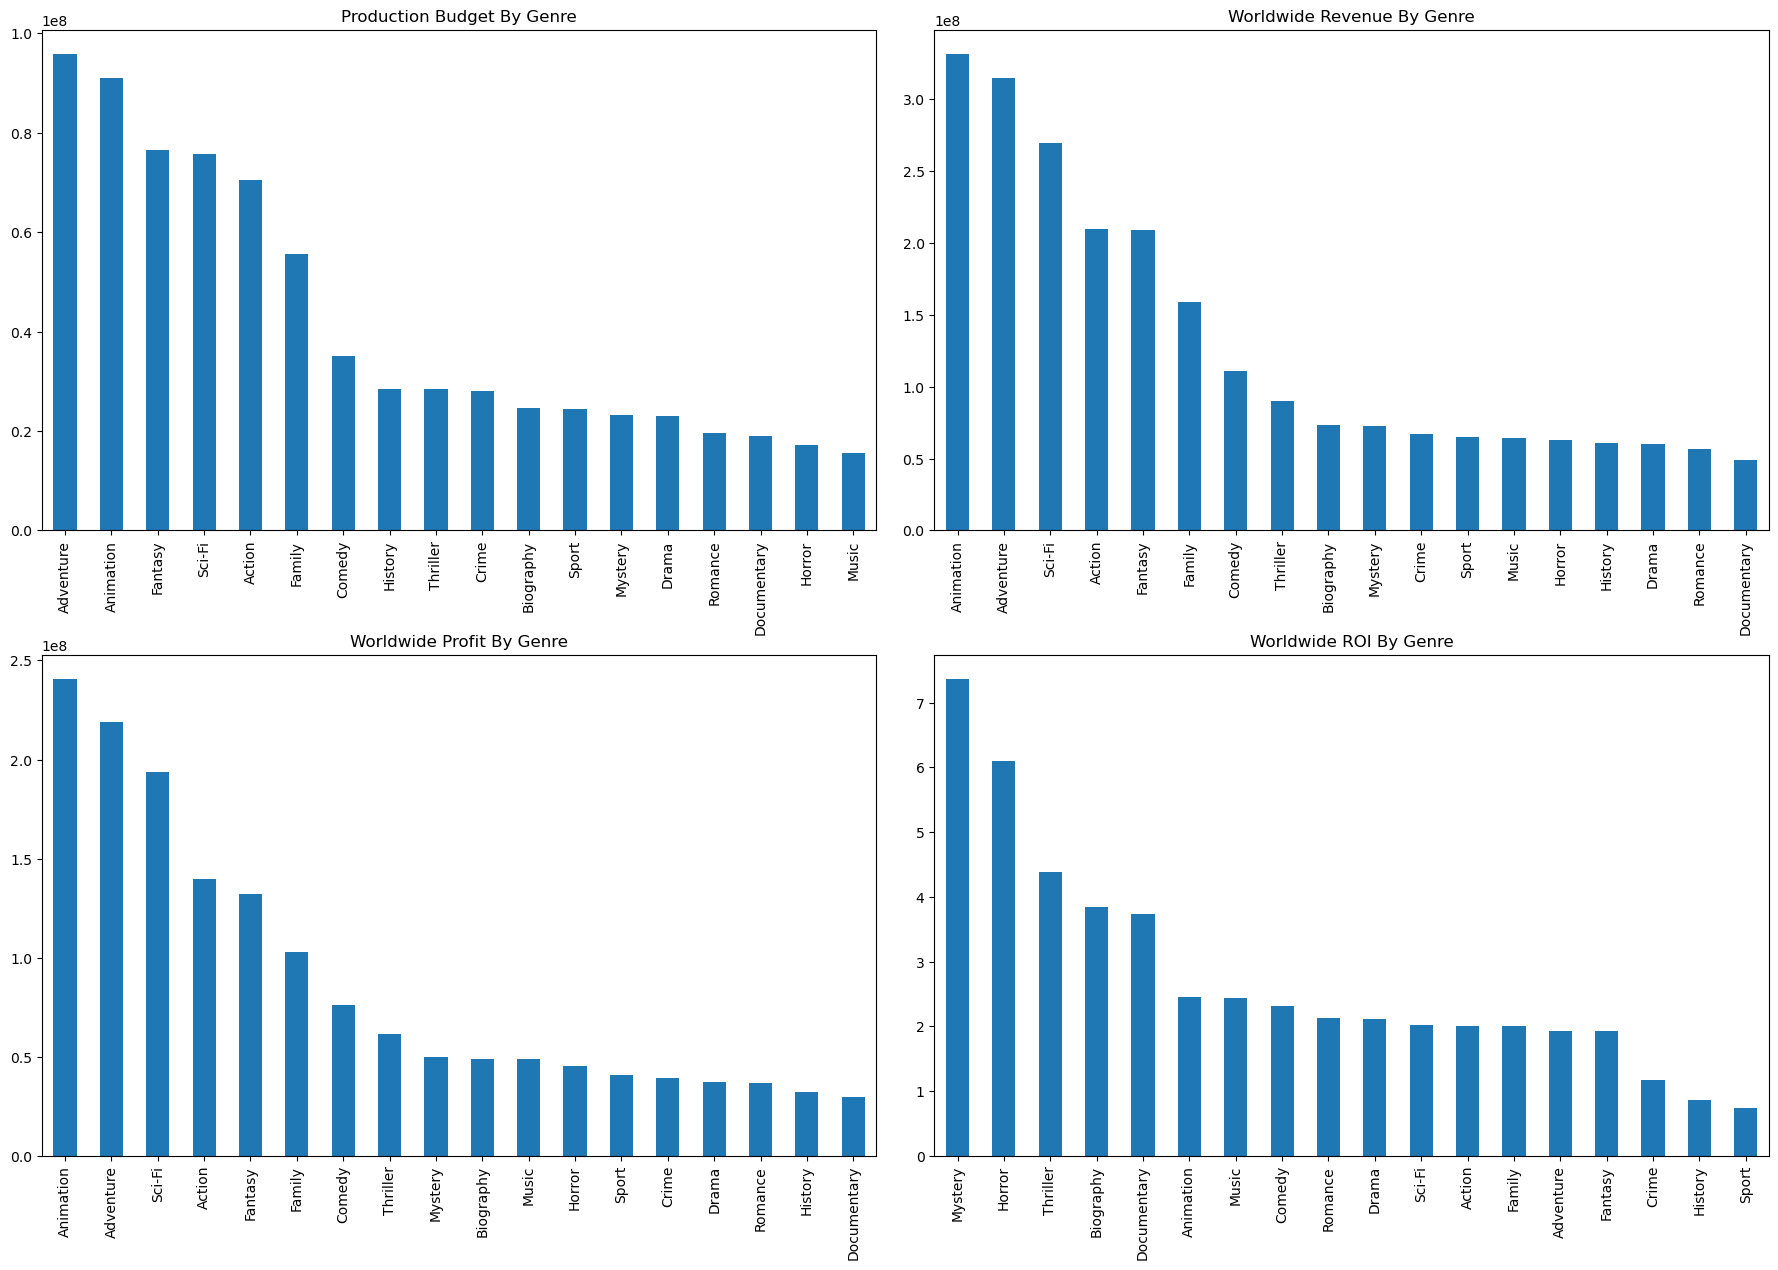

In [13]:
# Plot means of key metrics for each genre 
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Budgets
genre_vals = get_genre_vals('production_budget', df_merge)
mean_genre_vals = genre_vals.mean().sort_values(ascending=False)
mean_genre_vals.plot.bar(ax=axes[0,0])
axes[0,0].set_title('Production Budget By Genre')
plt.tight_layout()

# Worldwide gross earnings
genre_vals = get_genre_vals('worldwide_gross', df_merge)
mean_genre_vals = genre_vals.mean().sort_values(ascending=False)
mean_genre_vals.plot.bar(ax=axes[0,1])
axes[0,1].set_title('Worldwide Revenue By Genre')

# Worldwide profit
genre_vals = get_genre_vals('worldwide_profit', df_merge)
mean_genre_vals = genre_vals.mean().sort_values(ascending=False)
mean_genre_vals.plot.bar(ax=axes[1,0])
axes[1,0].set_title('Worldwide Profit By Genre')

# Worldwide ROI
genre_vals = get_genre_vals('worldwide_roi', df_merge)
mean_genre_vals = genre_vals.mean().sort_values(ascending=False)
mean_genre_vals.plot.bar(ax=axes[1,1])
axes[1,1].set_title('Worldwide ROI By Genre')

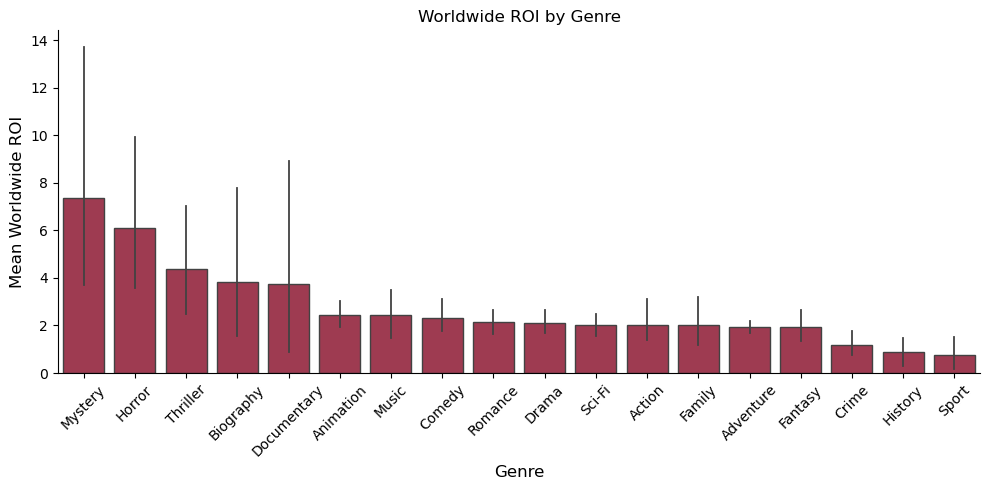

In [14]:
# Generate and save larger figure of Worldwide ROI by Genre
plt.figure(figsize=(10, 5))

genre_vals = get_genre_vals('worldwide_roi', df_merge)
order = genre_vals.mean().sort_values(ascending=False).index
genre_vals = genre_vals.melt(var_name='genre', value_name='ROI').dropna(subset=['ROI'])
sns.barplot(data=genre_vals, x='genre', y='ROI', order = order, color='#Af2a48', edgecolor='0.26', linewidth=1, errwidth=1.3)
plt.xticks(rotation=45)
plt.xlabel('Genre', size=12)
plt.ylabel('Mean Worldwide ROI', size=12)
plt.title('Worldwide ROI by Genre')
plt.tight_layout()
sns.despine()

if save_figs==1:
    plt.savefig('imgs/roi_by_genre.png', dpi=300, bbox_inches='tight')

#### We observe that movies belonging to the Mystery, Horror, and Thriller genres exhibit the highest mean ROIs. Given that a single movie can be associated with multiple genres, and considering the frequent overlap among our top three genres, we aimed to determine if specific combinations of these genres (e.g., a movie being both a Mystery and a Horror, or both a Horror and a Thriller) result in even higher ROIs. Next, we introduce a new column that identifies which of the top three genres (if any) the movie falls under and plot ROI for each genre combination. 

In [15]:
# Define the genres to check for
genres_to_check = ['Mystery', 'Horror', 'Thriller']

# Create the 'top_3_genres' column
df_merge['top_3_genres'] = df_merge['genres'].apply(lambda x: [1 if (x is not None) and (genre in x) else 0 for genre in genres_to_check])
df_merge['top_3_genres'] = df_merge['top_3_genres'].apply(tuple)
df_merge.groupby('top_3_genres')['worldwide_roi'].mean()

top_3_genres
(0, 0, 0)     2.196778
(0, 0, 1)     1.681655
(0, 1, 0)     2.924082
(0, 1, 1)     2.810900
(1, 0, 0)     1.127531
(1, 0, 1)     2.174798
(1, 1, 0)     3.606411
(1, 1, 1)    27.856694
Name: worldwide_roi, dtype: float64

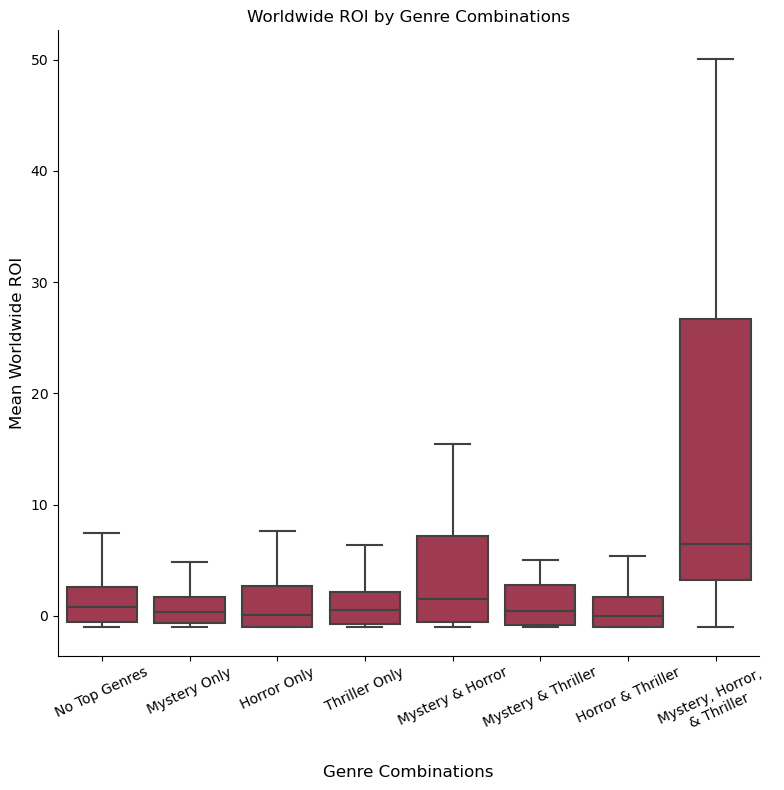

In [16]:
# Visualize ROIs for each genre combination
plt.figure(figsize=(8, 8))

['Mystery', 'Horror', 'Thriller']

order = [(0,0,0), (1,0,0), (0,1,0), (0,0,1), (1,1,0), (1,0,1), (0,1,1), (1,1,1)]
labels = ['No Top Genres', 'Mystery Only', 'Horror Only', 'Thriller Only',
          'Mystery & Horror', 'Mystery & Thriller', 'Horror & Thriller', 'Mystery, Horror, \n& Thriller' ]
          
sns.boxplot(data=df_merge, x='top_3_genres', y='worldwide_roi', order = order, showfliers=False, color='#Af2a48')

plt.xticks(range(len(order)), labels, rotation=25)
plt.xlabel('\nGenre Combinations', size=12)
plt.ylabel('Mean Worldwide ROI', size=12)
plt.title('Worldwide ROI by Genre Combinations')

# Show the plot
plt.tight_layout()
sns.despine()

if save_figs==1:
    plt.savefig('imgs/roi_by_combo_genres.png', dpi=300, bbox_inches='tight')

#### When considering individual genres, Mystery stands out with the highest ROI at 7.37. However, our follow-up analysis into genre combinations reveals an even more compelling insight: movies that encompass all three – Mystery, Horror, and Thriller – boast a mean ROI of 27.86. 

#### The above boxplot shows that Mystery+Horror+Thriller movie have a median ROI that surpasses the the 75th percentile of all other genre combinations, indicating that these movies typically perform better than others. The boxplot additionally shows large variability in ROI for Mystery+Horror+Thriller movies, hinting at the potential for massive returns. Going forward, we will focus on movies that are categorized under the Mystery, Horror, and Thriller genres. 

In [17]:
# Create a new df containing only the movies categorized under the Mystery, Horror, and Thriller genres
df_subset = df_merge[df_merge['top_3_genres'] == (1,1,1)].reset_index(drop=True)
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 34 non-null     int64  
 1   release_date       34 non-null     object 
 2   movie              34 non-null     object 
 3   production_budget  34 non-null     int64  
 4   domestic_gross     34 non-null     int64  
 5   worldwide_gross    34 non-null     int64  
 6   domestic_profit    34 non-null     int64  
 7   domestic_roi       34 non-null     float64
 8   worldwide_profit   34 non-null     int64  
 9   worldwide_roi      34 non-null     float64
 10  movie_id           34 non-null     object 
 11  primary_title      34 non-null     object 
 12  runtime_minutes    34 non-null     float64
 13  genres             34 non-null     object 
 14  averagerating      34 non-null     float64
 15  numvotes           34 non-null     int64  
 16  rt_cat             34 non-nu

# Runtime

#### We next turn our attention to another potentially important aspect of movies: their runtime. We specifically analyze how the length of a movie, categorized as short, medium, or long, influences its ROI.

In [18]:
# Get mean runtimes for short, medium, and long movies 
df_merge.groupby('rt_cat')['runtime_minutes'].mean()

rt_cat
Long      116.020375
Medium     92.232198
Short      75.942623
Name: runtime_minutes, dtype: float64

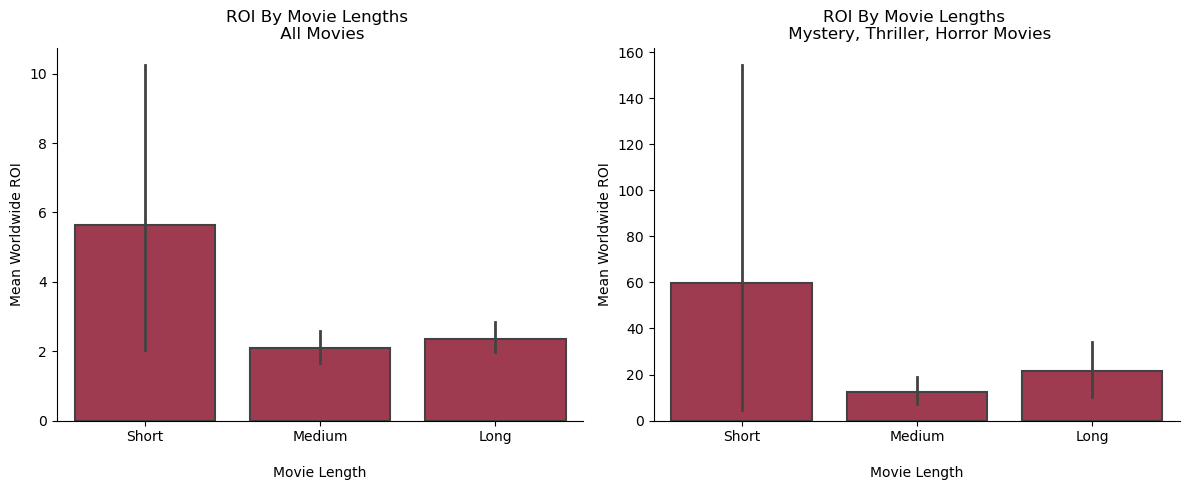

In [19]:
# Visualize ROI across short, medium, and long movies for all movies and movies containing the top genres 
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.barplot(x='rt_cat', y='worldwide_roi', data=df_merge, order=["Short", "Medium", "Long"], ax=axes[0], 
            color='#Af2a48', edgecolor='0.26', linewidth=1.5, errwidth=2)
axes[0].set_title('ROI By Movie Lengths \n All Movies')
axes[0].set_ylabel('Mean Worldwide ROI')
axes[0].set_xlabel('\nMovie Length')

sns.barplot(x='rt_cat', y='worldwide_roi', data=df_subset, order=["Short", "Medium", "Long"], ax=axes[1], 
            color='#Af2a48', edgecolor='0.26', linewidth=1.5, errwidth=2)
axes[1].set_title('ROI By Movie Lengths \n Mystery, Thriller, Horror Movies')
axes[1].set_ylabel('Mean Worldwide ROI')
axes[1].set_xlabel('\nMovie Length')

plt.tight_layout()
sns.despine()

if save_figs==1:
    plt.savefig('imgs/roi_by_movie_length.png', dpi=300, bbox_inches='tight')

#### Short movies outperform their longer counterparts in terms of ROI. This trend holds true across all movies for Mystery+Horror+Thriller movies. Though the shapes of the two above graphs are similar, the y axes are remarkably different from one another, with the ROI for short movies having a mean of 6 amongst all movies and a mean of 60 for Mystery+Horror+Thriller movies. The strategic choice is to focus on shorter Mystery+Horror+Thriller movies for optimal returns. 

# Annual Trends

#### We next consider how a movie's month of release can shape its financial trajectory. Movies tend to perform well in the summertime, but since we are focused on scary movies, we might see better results around Halloween. We plot ROI across months for all movies and for Mystery+Horror+Thriller movies to determine which release month will yield the best results. 

In [20]:
# Create a month column in the full df
df_merge['release_date'] = pd.to_datetime(df_merge['release_date'])
df_merge['month'] = df_merge['release_date'].dt.month

# Create a month column in the subset df
df_subset['release_date'] = pd.to_datetime(df_subset['release_date'])
df_subset['month'] = df_subset['release_date'].dt.month

In [21]:
# Check if data is present for all months in the full df
months_missing = [month for month in range(1, 13) if month not in df_merge.groupby('month')['worldwide_roi'].mean().index]
print(f"months missing from full df: {months_missing}")

# Check if data is present for all months in the subset df 
months_missing = [month for month in range(1, 13) if month not in df_subset.groupby('month')['worldwide_roi'].mean().index]
print(f"months missing from subset df: {months_missing}")

months missing from full df: []
months missing from subset df: [3, 6]


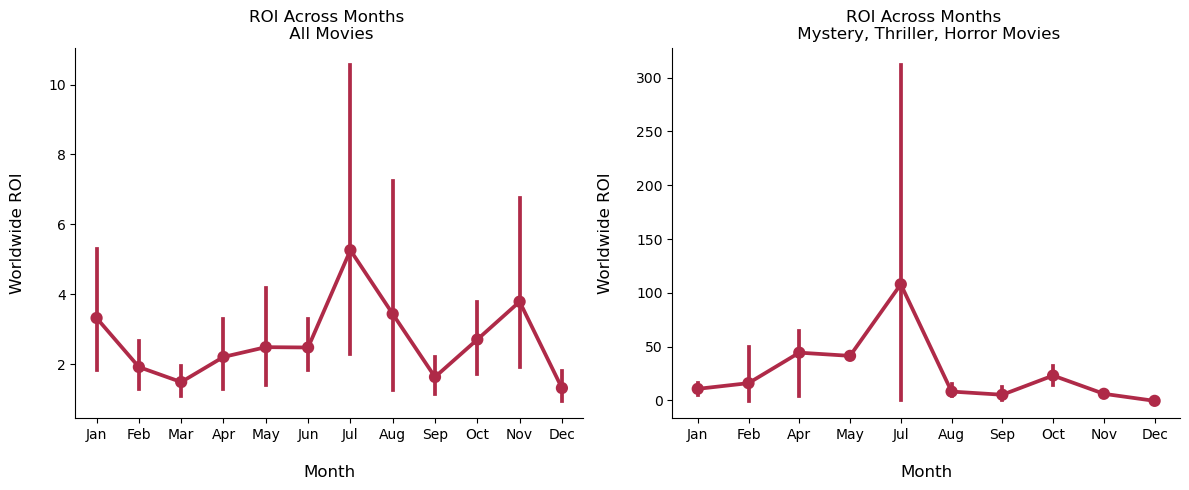

In [22]:
# Visualize ROI across months for all movies and movies containing the top genres 
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.pointplot(data=df_merge, x='month', y='worldwide_roi', color='#Af2a48', ax=axes[0])
axes[0].set_title('ROI Across Months \n All Movies')
axes[0].set_xlabel('\nMonth', size=12)
axes[0].set_ylabel('Worldwide ROI\n', size=12)
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

sns.pointplot(data=df_subset, x='month', y='worldwide_roi', color='#Af2a48', ax=axes[1])
axes[1].set_title('ROI Across Months \n Mystery, Thriller, Horror Movies')
axes[1].set_xlabel('\nMonth', size=12)
axes[1].set_ylabel('Worldwide ROI\n', size=12)
axes[1].set_xticklabels(['Jan', 'Feb', 'Apr', 'May', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
sns.despine()

if save_figs==1:
    plt.savefig('imgs/roi_across_months.png', dpi=300, bbox_inches='tight')

#### Contrary to our initial hunch, July outperforms all other months in terms of ROI both for all movies and for Mystery+Thriller+Horror movies. Mystery+Thriller+Horror movies have a slight increase in ROI in October, but it is insignificant when compared to the much larger increase seen in the heart of summer. Of note, July releases show more variability in ROI as compared to other months, again pointing to the possibility of a much higher return than would typically be expected. 

# Writers & Directors

#### Writers and directors can make or break a movie, so we next sought out industry mavens with a track record of producing Mystery+Thriller+Horror films with high ROIs. We filter for writers and directors who have been involved in 3 or more movies and have an average ROI greater than 10.

## Prepare writer & director data

In [23]:
# Import the director and writer data
# Connect to database, create dfs of relevant info, and save dfs as csv files for later use 
if conn_db == 1: 
    directors = pd.read_sql("""SELECT b.movie_id, b.original_title, p.primary_name AS director
                                FROM movie_basics AS b
                                JOIN directors AS d USING (movie_id)
                                JOIN persons AS p USING (person_id)
                                """, conn)
    directors.drop_duplicates(subset=['movie_id', 'original_title', 'director'], inplace=True)
    directors.to_csv('data/directors.csv', index=False)
    
    writers = pd.read_sql("""SELECT b.movie_id, b.original_title, p.primary_name AS writer
                            FROM movie_basics AS b
                            JOIN writers AS d USING (movie_id)
                            JOIN persons AS p USING (person_id)
                            """, conn)
    writers.drop_duplicates(subset=['movie_id', 'original_title', 'writer'], inplace=True)
    writers.to_csv('data/writers.csv', index=False)

In [24]:
# Import csv files of director and writer info
writers = pd.read_csv('data/writers.csv')
directors = pd.read_csv('data/directors.csv')

## Directors

In [25]:
# Make two data frames for df_merge combined with writers and directors separately
df_merge_writer = df_merge.merge(writers, on='movie_id', how='inner')
df_merge_director = df_merge.merge(directors, on='movie_id', how='inner')

In [26]:
# Make another data frame that has the count and the average of ROIs for each director
x = df_merge_director.groupby('director')['worldwide_roi'].mean()
y = df_merge_director.groupby('director')['worldwide_roi'].count()

# Filter the data to get the directors having an ROI above 10 with more than 3 movies
directors_roi_count = pd.concat([x, y], keys=['roi', 'count'], axis=1)
top_directors_roi_count = directors_roi_count[(directors_roi_count['roi']>10) & (directors_roi_count['count']>3)]
top_directors_roi_count

,roi,count
director,,
Christopher Landon,11.837767,4
James Wan,23.410492,4
Pierre Coffin,11.546172,4


In [27]:
# View James Wan movies 
df_merge_director[df_merge_director['director']=='James Wan']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi,...,primary_title,runtime_minutes,genres,averagerating,numvotes,rt_cat,top_3_genres,month,original_title,director
55,67,2015-04-03,furious 7,190000000,353007020,1518722794,163007020,0.857932,1328722794,6.993278,...,furious 7,137.0,"[Action, Crime, Thriller]",7.2,335074,Long,"(0, 0, 1)",4,Furious Seven,James Wan
117,36,2018-12-21,aquaman,160000000,335061807,1146894640,175061807,1.094136,986894640,6.168092,...,aquaman,143.0,"[Action, Adventure, Fantasy]",7.1,263328,Long,"(0, 0, 0)",12,Aquaman,James Wan
1091,93,2013-07-19,the conjuring,20000000,137400141,318000141,117400141,5.870007,298000141,14.900007,...,the conjuring,112.0,"[Horror, Mystery, Thriller]",7.5,397233,Long,"(1, 1, 1)",7,The Conjuring,James Wan
2107,63,2011-04-01,insidious,1500000,54009150,99870886,52509150,35.006100,98370886,65.580591,...,insidious,103.0,"[Horror, Mystery, Thriller]",6.9,254197,Long,"(1, 1, 1)",4,Insidious,James Wan


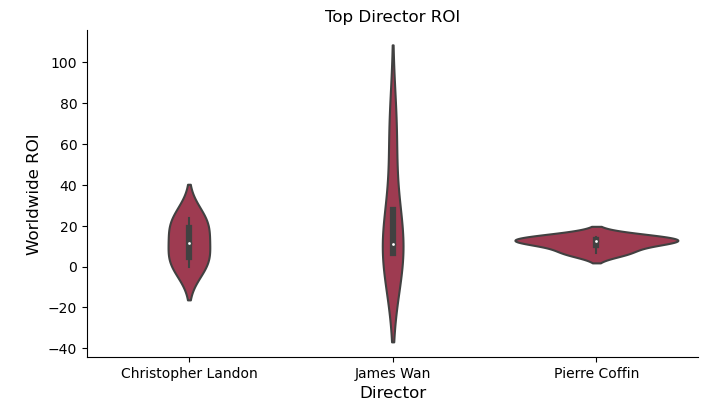

In [28]:
# Aggregate top director ROI values into a dataframe
top_director_rois = pd.DataFrame({'director': [],
                                    'worldwide_roi': []})

for director in top_directors_roi_count.index:
    director_rois = df_merge_director[df_merge_director['director']==director]['worldwide_roi'].reset_index(drop=True)
    director_name = [director] * len(director_rois)
    director_roi_df = pd.DataFrame({'director': director_name,
                                    'worldwide_roi': director_rois})
    top_director_rois = pd.concat([top_director_rois, director_roi_df])

# Visualize dataframe as violin plot
plt.figure(figsize=(7, 3))

sns.violinplot(data=top_director_rois, x='director', y='worldwide_roi', color='#Af2a48')

plt.tight_layout()
plt.title('Top Director ROI', fontsize=12)
plt.xlabel('Director', fontsize=12)
plt.ylabel('\nWorldwide ROI', fontsize=12)
sns.despine()

if save_figs==1:
    plt.savefig('imgs/top_directors_roi.png', dpi=300, bbox_inches='tight')

#### James Wan is our top recommendation for director, as he has 4 movies in our dataset, two of which are Mystery+Thriller+Horror movies and with an average ROI of 23.4. We have two alternative suggestions (Christopher Landon and Pierre Coffin) who also have 4 movies each within our dataset with an ROI of 11.84 and 11.45, respectively. 

### Writers

In [29]:
# Make another data frame that has the count and the average of ROIs for each director
x = df_merge_writer.groupby('writer')['worldwide_roi'].mean()
y = df_merge_writer.groupby('writer')['worldwide_roi'].count()

# Filter the data to get the writers having an ROI above 10 with more than 3 movies
writers_roi_count = pd.concat([x, y], keys=['roi', 'count'], axis=1)
top_writers_roi_count = writers_roi_count[(writers_roi_count['roi']>10) & (writers_roi_count['count']>3)]
top_writers_roi_count

,roi,count
writer,,
Christopher Landon,24.915210,6
Damien Chazelle,14.286455,4
James DeMonaco,15.293864,4
Oren Peli,27.218912,7


In [30]:
# View Oren Peli movies
df_merge_writer[df_merge_writer['writer']=='Oren Peli']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi,...,primary_title,runtime_minutes,genres,averagerating,numvotes,rt_cat,top_3_genres,month,original_title,writer
3492,7,2015-10-23,paranormal activity: the ghost dimension,10000000,18297124,77959374,8297124,0.829712,67959374,6.795937,...,paranormal activity: the ghost dimension,88.0,"[Horror, Mystery, Thriller]",4.6,22361,Medium,"(1, 1, 1)",10,Paranormal Activity: The Ghost Dimension,Oren Peli
3943,51,2011-10-21,paranormal activity 3,5000000,104028807,207039844,99028807,19.805761,202039844,40.407969,...,paranormal activity 3,83.0,"[Horror, Mystery, Thriller]",5.8,85689,Short,"(1, 1, 1)",10,Paranormal Activity 3,Oren Peli
3952,59,2012-10-19,paranormal activity 4,5000000,53900335,142817992,48900335,9.780067,137817992,27.563598,...,paranormal activity 4,88.0,"[Horror, Mystery, Thriller]",4.6,58408,Medium,"(1, 1, 1)",10,Paranormal Activity 4,Oren Peli
3961,70,2014-01-03,paranormal activity: the marked ones,5000000,32462372,90904854,27462372,5.492474,85904854,17.180971,...,paranormal activity: the marked ones,84.0,"[Horror, Mystery, Thriller]",5.0,37147,Short,"(1, 1, 1)",1,Paranormal Activity: The Marked Ones,Oren Peli
4044,81,2015-05-15,area 51,5000000,7556,7556,-4992444,-0.998489,-4992444,-0.998489,...,area 51,91.0,"[Horror, Sci-Fi, Thriller]",4.2,11537,Medium,"(0, 1, 1)",5,Area 51,Oren Peli
4217,65,2010-10-20,paranormal activity 2,3000000,84752907,177512032,81752907,27.250969,174512032,58.170677,...,paranormal activity 2,91.0,[Horror],5.7,93122,Medium,"(0, 1, 0)",10,Paranormal Activity 2,Oren Peli
4589,18,2012-05-25,chernobyl diaries,1000000,18119640,42411721,17119640,17.119640,41411721,41.411721,...,chernobyl diaries,86.0,"[Horror, Mystery, Thriller]",5.0,60304,Medium,"(1, 1, 1)",5,Chernobyl Diaries,Oren Peli


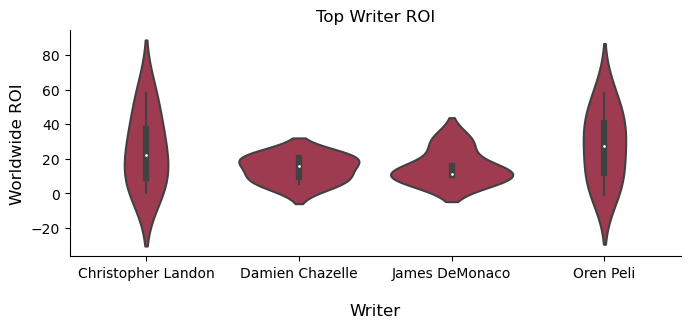

In [32]:
# Aggregate top writer ROI values into a dataframe
top_writer_rois = pd.DataFrame({'writer': [],
                                    'worldwide_roi': []})

for writer in top_writers_roi_count.index:
    writer_rois = df_merge_writer[df_merge_writer['writer']==writer]['worldwide_roi'].reset_index(drop=True)
    writer_name = [writer] * len(writer_rois)
    writer_roi_df = pd.DataFrame({'writer': writer_name,
                                    'worldwide_roi': writer_rois})
    top_writer_rois = pd.concat([top_writer_rois, writer_roi_df])

# Visualize dataframe as violin plot
plt.figure(figsize=(7, 3))

sns.violinplot(data=top_writer_rois, x='writer', y='worldwide_roi', color='#Af2a48')

plt.tight_layout()
plt.title('Top Writer ROI', fontsize=12)
plt.xlabel('\nWriter', fontsize=12)
plt.ylabel('Worldwide ROI', fontsize=12)
sns.despine()

if save_figs==1:
    plt.savefig('imgs/top_writers_roi.png', dpi=300, bbox_inches='tight')

#### Oren Peli is our top recommendation for writer, as he has 7 movies in our dataset, averaging an ROI of 27.22, and all of his movies have at least one of the top three genres.

#### Christopher Landon is a close second, as he also has 6 movies in our dataset, averaging an ROI of 24.9, and all of his movies also have at least one of the top three genres.

#### We have two alternative suggestions (James DeMonaco and Damien Chazelle) who each have 4 movies within our dataset with an ROI of 15.29 and 14.29, respectively.¶

## Recommendations

#### Drawing from our analysis of movie trends and performance metrics, we created a movie blueprint that geared towards the objective of maximizing returns on investment:

- #### Develop a narrative that blends Mystery, Horror, and Thriller.
- #### Keep the movie brief (around 75 minutes), as shorter movies are more cost-effective, and therefore, have higher ROIs.
- #### Release the movie in July. Contrary to the conventional wisdom of releasing horror films around Halloween, our analysis found July is the optimal time to release the movie.
- #### Recruit James Wan, Christopher Landon, or Pierre Coffin to direct the movie. These directors have a proven track-record of creating films with high ROI. 
- #### Recruit Oren Peli, Christopher Landon, James DeMonaco, or Damien Chazelle to write the movie. These writers have have consistently demonstrated their ability to write narratives that drive impressive financial returns. 

#### Our analysis indicate that combining these four recommendations will maximize the chance that each dollar spent on the movie will yield a high return on investment. This blueprint offers a strategic path forward in the competitive world of film and provides a tailored strategy to turn a movie idea into a financial success.